In [1]:
from linares_plot import *
import statsmodels.formula.api as smf
from scipy.stats import norm

In [2]:
%run "C:\\Users\\David\\Documents\\GitHub\\wm_distractor_filtering\\psychophysics\\Funciones.ipynb"

In [3]:
df_psy = pd.read_csv('C:\\Users\\David\\Dropbox\\KAROLINSKA\\task\\POSITIONS\\L3_d0,2&7_rad8_resp_same\\behaviour_psychophysics_corrected')
df_fMRI = pd.read_csv('C:\\Users\\David\\Dropbox\\KAROLINSKA\\fMRI_beh_analysis\\behaviour_fMRI')

In [4]:
df_analysis_psy = df_psy[[ 'A_err',  'Interference', 'A_R', 'A_err_abs', 'delay', 'distance', 'subject',
                  'order', 'orient', 'type', 'A_dist', 'A_T',  'A_err_int_theoretical', 'A_res', 'A_err_theoretical' ]]

df_analysis_fMRI = df_fMRI[[ 'A_err',  'Interference', 'A_R', 'A_err_abs', 'delay', 'distance', 'subject',
                  'order', 'orient', 'type', 'A_dist', 'A_T',  'A_err_int_theoretical', 'A_res', 'A_err_theoretical' ]]



df_analysis_psy['environment']='psychophysics'
df_analysis_fMRI['environment']='fMRI'

df_analysis = pd.concat([df_analysis_psy, df_analysis_fMRI], ignore_index=True)

print('N = ' + str(len(df_analysis) ))
print('N psychophysics = ' + str(len(df_analysis_psy) ))
print('N fMRI = ' + str(len(df_analysis_fMRI) ))

N = 6661
N psychophysics = 4774
N fMRI = 1887


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
df_analysis = df_analysis.loc[df_analysis['type']!=4]
df_analysis.rename(columns={'orient': 'cond'}, inplace=True)
df_analysis['cw_ccw']=[cw_ccw_detector(df_analysis['A_T'].iloc[i], df_analysis['A_dist'].iloc[i]) for i in range(0, len(df_analysis))]

df_analysis['Interference_col'] = df_analysis['A_err'].copy()
df_analysis.loc[df_analysis['cw_ccw']=='cw', 'Interference_col'] = df_analysis.loc[df_analysis['cw_ccw']=='cw', 'Interference_col']*-1

df_analysis['sex']=[male_female(df_analysis['subject'].loc[ind]) for ind in df_analysis.index]

#In case you want to try other alternatives
#df_analysis.rename(columns={'A_err_theoretical': 'A_err'}, inplace=True)
#df_analysis.rename(columns={'A_err_jh': 'A_err'}, inplace=True)

#correction of the types 1: <20, 2: 20-30, 3: >30
for i in df_analysis.index:
    if df_analysis.loc[i].distance <20 :
        t =1
    elif df_analysis.loc[i].distance >30 :
        t =3
    else:
        t=2
    
    #print(t)
    df_analysis.loc[i, 'type'] = t



df_analysis['dist_in_out'] = df_analysis['type'].copy() 
df_analysis['dist_in_out'] = df_analysis['dist_in_out'].replace([1 ,2, 3], ['in', 'in', 'out'])



df_analysis['ord_del_cond'] = df_analysis[['delay','order']].sum(axis=1)
df_analysis['ord_del_cond'] = df_analysis['ord_del_cond'].replace([1.2, 2.2, 8, 9], ['1_d02', '2_d02', '1_d7', '2_d7'])



In [6]:
##### MEAN OF CW AND CCW COLLAPSING IN 

means_cw={}

for Subj in df_analysis.subject.unique():
    d_subj = df_analysis.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for Dist in df_analysis.dist_in_out.unique():
            for Cond_4 in df_analysis.ord_del_cond.unique():
                mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['ord_del_cond']==Cond_4) &
                                           (d_subj['dist_in_out']==Dist), 'A_err_theoretical'   ].mean(), 3)
                means_cw[str(Subj)  + '_' + str(Cond_4) + '_' + str(Dist) + '_' + ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df_analysis.index:
    or_ = df_analysis.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df_analysis.loc[i, 'subject'])+ '_' + df_analysis.loc[i, 'ord_del_cond'] +'_' + df_analysis.loc[i, 'dist_in_out'] + '_'+ or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append( (df_analysis.loc[i, 'A_err_theoretical'] - means_cw[idx])/2 )  
    elif or_ =='cw':
        cw_ccw_distance.append( (means_cw[idx] - df_analysis.loc[i, 'A_err_theoretical'])/2 )  
    else:
        print('Error')
    


df_analysis['distance_A_err'] = cw_ccw_distance

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


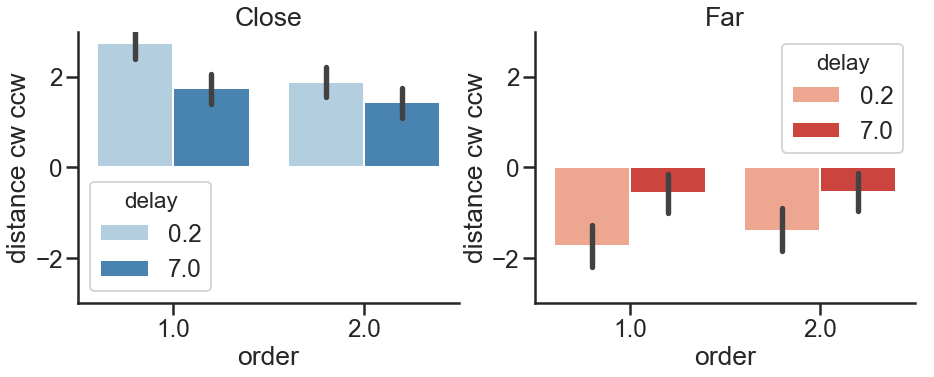

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     distance_A_err
No. Observations:      6362        Method:                 REML          
No. Groups:            27          Scale:                  29.0392       
Min. group size:       107         Likelihood:             -19774.8987   
Max. group size:       354         Converged:              Yes           
Mean group size:       235.6                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       3.627    0.428  8.474 0.000  2.788  4.466
dist_in_out[T.out]             -5.782    0.646 -8.945 0.000 -7.049 -4.515
delay                          -0.222    0.080 -2.758 0.006 -0.379 -0.064
delay:dist_in_out[T.out]        0.447    0.129  3.452 0.

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 3920    Method:             REML          
No. Groups:       27      Scale:              23.4243       
Min. group size:  73      Likelihood:         -11794.1352   
Max. group size:  181     Converged:          Yes           
Mean group size:  145.2                                     
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      3.528     0.561   6.285  0.000   2.428   4.628
delay         -0.216     0.072  -2.985  0.003  -0.357  -0.074
order         -0.849     0.228  -3.725  0.000  -1.295  -0.402
delay:order    0.083     0.046   1.831  0.067  -0.006   0.173
subject Var    4.981     0.296                               

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Var

In [7]:
fig = plt.figure()
fig.set_size_inches(15, 5)
fig.tight_layout()
#fig.suptitle('Order delay distance', fontsize=30)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot( ax= ax1, x="order", y="distance_A_err", hue='delay', data=df_analysis.loc[df_analysis['dist_in_out']=='in'], palette='Blues')
sns.barplot( ax= ax2, x="order", y="distance_A_err", hue='delay', data=df_analysis.loc[df_analysis['dist_in_out']=='out'], palette='Reds')
axes=[ax1, ax2]
Titles=['Close', 'Far']

for i, Ax in enumerate(axes):
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    Ax.title.set_text(Titles[i])
    #Ax.legend_.remove()
    #Ax.set_xticklabels(['in','out'])
    #Ax.set_xlabel('Distance T-Dist')
    Ax.set_ylabel('distance cw ccw')
    Ax.set_ylim(-3,3)

    
    


plt.show()

#Are the residuals normally distributed?
# sns.distplot(result.resid)
# plt.show()
# #Residuals distribution
# print(scipy.stats.anderson(x=result.resid, dist='norm'))
# #Residuals distribution
# print(scipy.stats.shapiro(result.resid))


result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out ", data=df_analysis, groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())


In [8]:
col_02 = '#457b9d'
col_7 = '#a82a33'

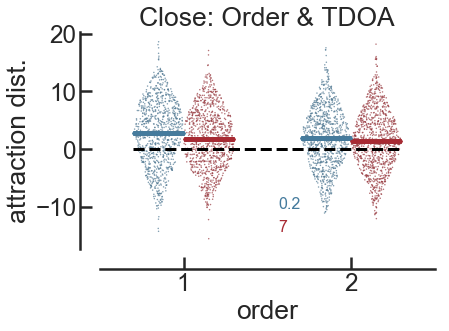

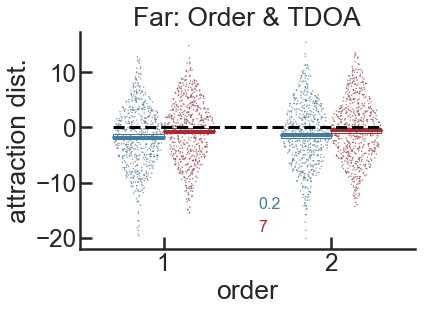

In [9]:
linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette= [col_02, col_7], 
              order=[1,2], hue_order=[0.2, 7], point_size=1.5, alpha=0.7, width=0.6 )  
#plt.ylim(-10,15)
plt.plot([-.3 ,1.3], [0,0], 'k--')
plt.ylabel('attraction dist.')
plt.title('Close: Order & TDOA')
plt.show(block=False)


linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], 
              order=[1,2], hue_order=[0.2, 7], point_size=1.5, alpha=0.7, width=0.6, sep_axis=False )  
#plt.ylim(-10,15)
plt.plot([-.3 ,1.3], [0,0], 'k--')
plt.ylabel('attraction dist.')
plt.title('Far: Order & TDOA')
plt.show(block=False)

In [10]:
df_analysis.columns

Index(['A_err', 'Interference', 'A_R', 'A_err_abs', 'delay', 'distance',
       'subject', 'order', 'cond', 'type', 'A_dist', 'A_T',
       'A_err_int_theoretical', 'A_res', 'A_err_theoretical', 'environment',
       'cw_ccw', 'Interference_col', 'sex', 'dist_in_out', 'ord_del_cond',
       'distance_A_err'],
      dtype='object')

In [9]:
df_analysis

,A_err,Interference,A_R,A_err_abs,delay,distance,subject,order,cond,type,...,A_err_int_theoretical,A_res,A_err_theoretical,environment,cw_ccw,Interference_col,sex,dist_in_out,ord_del_cond,distance_A_err
0,-2.497,-2.497,53.965,6.0,7.0,14.5,1.0,2.0,2.0,1.0,...,6.0,51.0,6.0,psychophysics,ccw,-2.497,F,in,2_d7,0.9445
1,14.948,14.948,307.219,13.0,7.0,19.2,1.0,1.0,2.0,1.0,...,13.0,302.0,13.0,psychophysics,ccw,14.948,F,in,1_d7,4.9120
3,-2.721,-2.721,146.091,3.0,7.0,28.3,1.0,2.0,2.0,2.0,...,-3.0,148.0,-3.0,psychophysics,ccw,-2.721,F,in,2_d7,-3.5555
4,-11.073,-11.073,228.611,1.0,7.0,10.8,1.0,2.0,2.0,1.0,...,-1.0,227.0,-1.0,psychophysics,ccw,-11.073,F,in,2_d7,-2.5555
5,-0.068,0.068,61.965,7.0,7.0,90.0,1.0,2.0,0.0,3.0,...,7.0,59.0,7.0,psychophysics,cw,0.068,F,out,2_d7,-1.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6656,-6.000,-6.000,310.000,6.0,0.2,90.0,25.0,1.0,0.0,3.0,...,-6.0,310.0,-6.0,fMRI,ccw,-6.000,F,out,1_d02,-3.7750
6657,-16.000,16.000,68.000,16.0,7.0,68.0,25.0,1.0,0.0,3.0,...,16.0,68.0,-16.0,fMRI,cw,16.000,F,out,1_d7,7.9250
6658,0.000,0.000,212.000,0.0,7.0,95.0,25.0,1.0,0.0,3.0,...,0.0,212.0,0.0,fMRI,ccw,0.000,F,out,1_d7,-2.0555
6659,8.000,8.000,201.000,8.0,7.0,86.0,25.0,1.0,0.0,3.0,...,8.0,201.0,8.0,fMRI,ccw,8.000,F,out,1_d7,1.9445


# Precision

In [12]:
#all

In [9]:
col_02 = '#457b9d'
col_7 = '#a82a33'
colors_use = [col_02, col_7]
alphas=[0.8, 0.4]

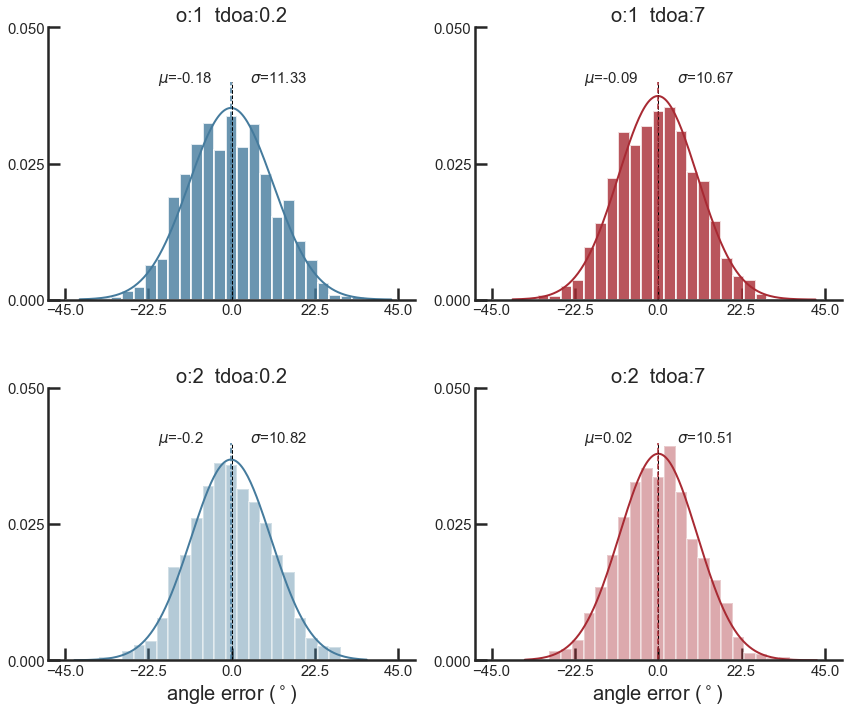

In [13]:
f = plt.figure(figsize=(12,10))

for idx_order, order_ in enumerate([1, 2]):
    for idx_tdoa, TDOA in enumerate([0.2, 7]):
        number_plot = int(str(2) + str(2) + str(2*idx_order+idx_tdoa +1 ))
        #print(number_plot)
        plt.subplot(number_plot)
        color_ = colors_use[idx_tdoa]
        err_ = df_analysis.loc[(df_analysis['order']==order_) & (df_analysis['delay']==TDOA), 'A_err'  ].values
        #
        sns.distplot(err_ , bins=np.linspace(-45,45,30), 
              fit=norm, kde=False, fit_kws={"color":color_, 'linewidth':2}, color=color_, hist_kws={'alpha':alphas[idx_order]} )
        #
        plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
        plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
        plt.gca().get_xaxis().tick_bottom()                                                                                         
        plt.gca().get_yaxis().tick_left()
        plt.gca().tick_params(direction='in') #direction
        mu_, sigma_ = norm.fit(err_)
        #print(mu_, sigma_)
        #
        plt.plot([0,0], [0,0.04], 'k--', linewidth=1)
        plt.plot([mu_,mu_], [0,0.04], color=color_, linestyle= '--', linewidth=1.5)
        #
        plt.text(5, 0.04, r'$\sigma$=' + str(np.round(sigma_,2)), fontsize=15)
        plt.text(-20, 0.04, r'$\mu$=' + str(np.round(mu_,2)), fontsize=15)
        #
        if order_==2:
            plt.xlabel(r'angle error ($^\circ$)', fontsize=20)
        else:
            plt.xlabel(r'', fontsize=20)
            
        plt.ylim(0, 0.05)
        plt.yticks([0, 0.025, 0.05], fontsize=15)
        plt.xticks([-45, -22.5, 0, 22.5, 45], fontsize=15)
        plt.title('o:' + str(order_) + '  tdoa:' + str(TDOA), fontsize=20)
        


plt.tight_layout(h_pad=5)
#plt.savefig('C:\\Users\\David\\Desktop\\precision_tdoa.svg', transparent=True )

In [12]:
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

###### Anova model
mod = ols(formula=' A_err~ ord_del_cond', data=df_analysis).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print( '                                 ')
print( '                                 Anova Table')
print( '==============================================================================')
print( aov_table)
print( '==============================================================================')
print( '                                 ')

####### Multiple comparisons
tukey = pairwise_tukeyhsd(endog=df_analysis['A_err'].values, groups=df_analysis['ord_del_cond'].values,  alpha=0.05)
print( tukey.summary()    )

print( '                                 ')


print( '                                 ')
print( '                                 ')

                                 
                                 Anova Table
                     sum_sq      df         F    PR(>F)
ord_del_cond      47.370699     3.0  0.134519  0.939503
Residual      746319.748267  6358.0       NaN       NaN
                                 
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
1_d02   1_d7   0.085   -0.9058 1.0758 False 
1_d02  2_d02   -0.019  -1.0164 0.9783 False 
1_d02   2_d7   0.1983  -0.7867 1.1833 False 
 1_d7  2_d02  -0.1041  -1.0941 0.8859 False 
 1_d7   2_d7   0.1133  -0.8643 1.0908 False 
2_d02   2_d7   0.2173  -0.7668 1.2015 False 
--------------------------------------------
                                 
                                 
                                 


In [14]:
o1_tdoa02 = df_analysis.loc[(df_analysis['order']==1) & (df_analysis['delay']==0.2), 'A_err'  ].values
o1_tdoa7 =df_analysis.loc[(df_analysis['order']==1) & (df_analysis['delay']==7), 'A_err'  ].values
o2_tdoa02 =df_analysis.loc[(df_analysis['order']==2) & (df_analysis['delay']==0.2), 'A_err'  ].values
o2_tdoa7 =df_analysis.loc[(df_analysis['order']==2) & (df_analysis['delay']==7), 'A_err'  ].values


print(scipy.stats.levene(o1_tdoa02, o1_tdoa7, o2_tdoa02, o2_tdoa7))
print('')
print('')

print(scipy.stats.levene(o1_tdoa02, o2_tdoa7 ))
print(scipy.stats.levene(o1_tdoa02, o2_tdoa02 ))
print(scipy.stats.levene(o1_tdoa02, o1_tdoa7 ))
print('')
print(scipy.stats.levene(o1_tdoa7, o2_tdoa02 ))
print(scipy.stats.levene(o2_tdoa02, o2_tdoa7 ))




LeveneResult(statistic=4.660457683134029, pvalue=0.0029502501491133447)


LeveneResult(statistic=12.950040984855457, pvalue=0.00032476800675660446)
LeveneResult(statistic=5.437566709292283, pvalue=0.019771539332440448)
LeveneResult(statistic=6.60598832737218, pvalue=0.010209099941148594)

LeveneResult(statistic=0.035409121265098584, pvalue=0.8507530218367597)
LeveneResult(statistic=1.49673398436908, pvalue=0.22126462789703003)


In [ ]:
#close

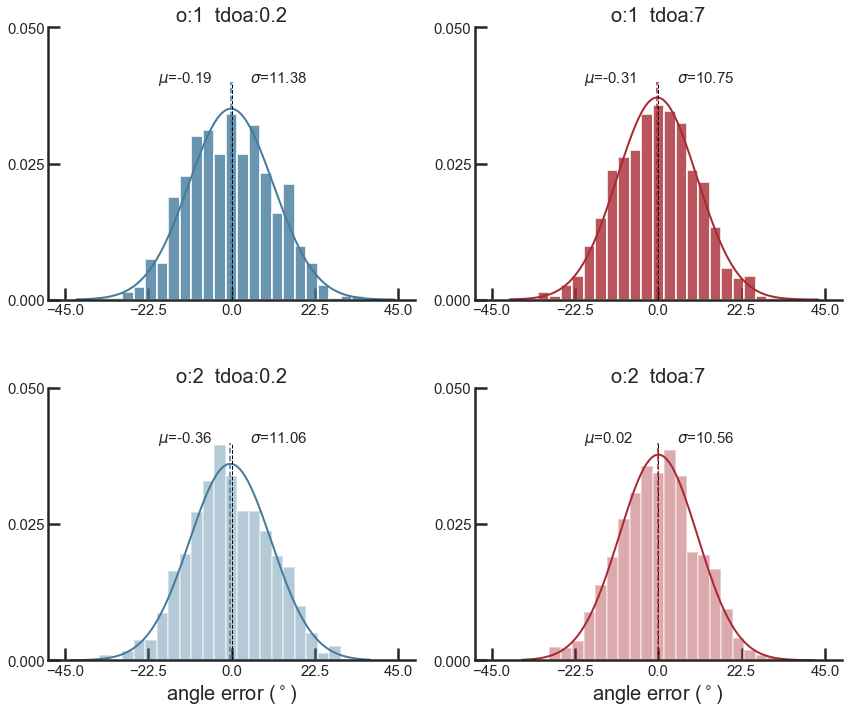

In [47]:
f = plt.figure(figsize=(12,10))

for idx_order, order_ in enumerate([1, 2]):
    for idx_tdoa, TDOA in enumerate([0.2, 7]):
        number_plot = int(str(2) + str(2) + str(2*idx_order+idx_tdoa +1 ))
        #print(number_plot)
        plt.subplot(number_plot)
        color_ = colors_use[idx_tdoa]
        err_ = df_analysis.loc[(df_analysis['dist_in_out']=='in') & (df_analysis['order']==order_) & (df_analysis['delay']==TDOA), 'A_err'  ].values
        #
        sns.distplot(err_ , bins=np.linspace(-45,45,30), 
              fit=norm, kde=False, fit_kws={"color":color_, 'linewidth':2}, color=color_, hist_kws={'alpha':alphas[idx_order]} )
        #
        plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
        plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
        plt.gca().get_xaxis().tick_bottom()                                                                                         
        plt.gca().get_yaxis().tick_left()
        plt.gca().tick_params(direction='in') #direction
        mu_, sigma_ = norm.fit(err_)
        #print(mu_, sigma_)
        #
        plt.plot([0,0], [0,0.04], 'k--', linewidth=1)
        plt.plot([mu_,mu_], [0,0.04], color=color_, linestyle= '--', linewidth=1.5)
        #
        plt.text(5, 0.04, r'$\sigma$=' + str(np.round(sigma_,2)), fontsize=15)
        plt.text(-20, 0.04, r'$\mu$=' + str(np.round(mu_,2)), fontsize=15)
        #
        if order_==2:
            plt.xlabel(r'angle error ($^\circ$)', fontsize=20)
        else:
            plt.xlabel(r'', fontsize=20)
            
        plt.ylim(0, 0.05)
        plt.yticks([0, 0.025, 0.05], fontsize=15)
        plt.xticks([-45, -22.5, 0, 22.5, 45], fontsize=15)
        plt.title('o:' + str(order_) + '  tdoa:' + str(TDOA), fontsize=20)
        


plt.tight_layout(h_pad=5)

In [15]:
o1_tdoa02 = df_analysis.loc[(df_analysis['dist_in_out']=='in') & (df_analysis['order']==1) & (df_analysis['delay']==0.2), 'A_err'  ].values
o1_tdoa7 =df_analysis.loc[(df_analysis['dist_in_out']=='in') & (df_analysis['order']==1) & (df_analysis['delay']==7), 'A_err'  ].values
o2_tdoa02 =df_analysis.loc[(df_analysis['dist_in_out']=='in') & (df_analysis['order']==2) & (df_analysis['delay']==0.2), 'A_err'  ].values
o2_tdoa7 =df_analysis.loc[(df_analysis['dist_in_out']=='in') & (df_analysis['order']==2) & (df_analysis['delay']==7), 'A_err'  ].values

print(scipy.stats.levene(o1_tdoa02, o1_tdoa7, o2_tdoa02, o2_tdoa7))
print('')
print('')


print(scipy.stats.levene(o1_tdoa02, o2_tdoa7 ))
print(scipy.stats.levene(o1_tdoa02, o2_tdoa02 ))
print(scipy.stats.levene(o1_tdoa02, o1_tdoa7 ))
print('')
print(scipy.stats.levene(o1_tdoa7, o2_tdoa02 ))
print(scipy.stats.levene(o2_tdoa02, o2_tdoa7 ))

LeveneResult(statistic=3.2499131197508184, pvalue=0.020921420055085353)


LeveneResult(statistic=8.958708719333588, pvalue=0.0027958055553972865)
LeveneResult(statistic=1.8427180200421651, pvalue=0.17479282675244798)
LeveneResult(statistic=4.866070219648219, pvalue=0.02750682942744374)

LeveneResult(statistic=0.6691993492579513, pvalue=0.4134311448748266)
LeveneResult(statistic=2.533431173265886, pvalue=0.111617324771346)


In [ ]:
#far

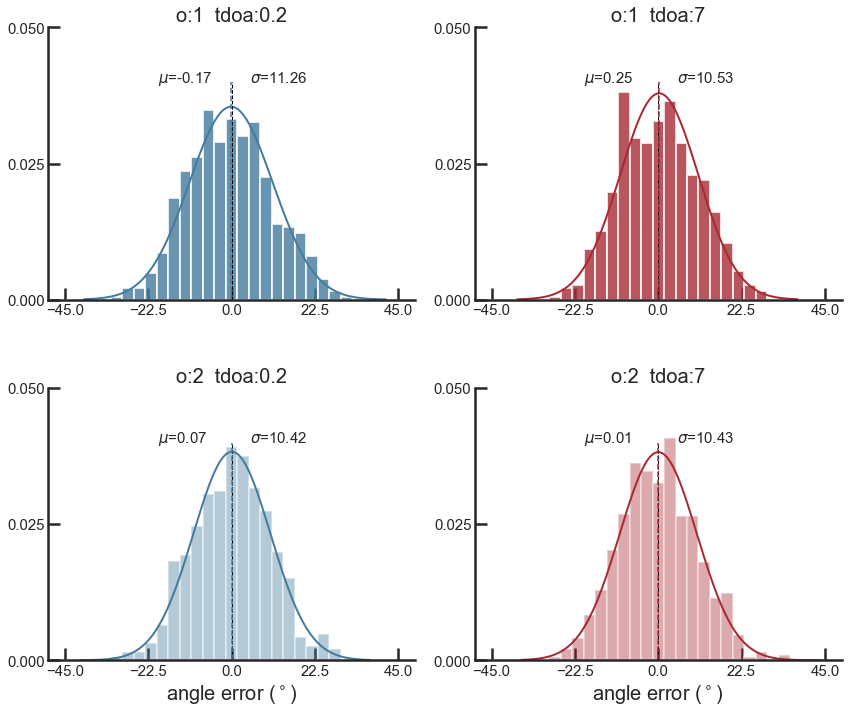

In [48]:
f = plt.figure(figsize=(12,10))

for idx_order, order_ in enumerate([1, 2]):
    for idx_tdoa, TDOA in enumerate([0.2, 7]):
        number_plot = int(str(2) + str(2) + str(2*idx_order+idx_tdoa +1 ))
        #print(number_plot)
        plt.subplot(number_plot)
        color_ = colors_use[idx_tdoa]
        err_ = df_analysis.loc[(df_analysis['dist_in_out']=='out') & (df_analysis['order']==order_) & (df_analysis['delay']==TDOA), 'A_err'  ].values
        #
        sns.distplot(err_ , bins=np.linspace(-45,45,30), 
              fit=norm, kde=False, fit_kws={"color":color_, 'linewidth':2}, color=color_, hist_kws={'alpha':alphas[idx_order]} )
        #
        plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
        plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
        plt.gca().get_xaxis().tick_bottom()                                                                                         
        plt.gca().get_yaxis().tick_left()
        plt.gca().tick_params(direction='in') #direction
        mu_, sigma_ = norm.fit(err_)
        #print(mu_, sigma_)
        #
        plt.plot([0,0], [0,0.04], 'k--', linewidth=1)
        plt.plot([mu_,mu_], [0,0.04], color=color_, linestyle= '--', linewidth=1.5)
        #
        plt.text(5, 0.04, r'$\sigma$=' + str(np.round(sigma_,2)), fontsize=15)
        plt.text(-20, 0.04, r'$\mu$=' + str(np.round(mu_,2)), fontsize=15)
        #
        if order_==2:
            plt.xlabel(r'angle error ($^\circ$)', fontsize=20)
        else:
            plt.xlabel(r'', fontsize=20)
            
        plt.ylim(0, 0.05)
        plt.yticks([0, 0.025, 0.05], fontsize=15)
        plt.xticks([-45, -22.5, 0, 22.5, 45], fontsize=15)
        plt.title('o:' + str(order_) + '  tdoa:' + str(TDOA), fontsize=20)
        


plt.tight_layout(h_pad=5)

In [16]:
o1_tdoa02 = df_analysis.loc[(df_analysis['dist_in_out']=='out') & (df_analysis['order']==1) & (df_analysis['delay']==0.2), 'A_err'  ].values
o1_tdoa7 =df_analysis.loc[(df_analysis['dist_in_out']=='out') & (df_analysis['order']==1) & (df_analysis['delay']==7), 'A_err'  ].values
o2_tdoa02 =df_analysis.loc[(df_analysis['dist_in_out']=='out') & (df_analysis['order']==2) & (df_analysis['delay']==0.2), 'A_err'  ].values
o2_tdoa7 =df_analysis.loc[(df_analysis['dist_in_out']=='out') & (df_analysis['order']==2) & (df_analysis['delay']==7), 'A_err'  ].values

print(scipy.stats.levene(o1_tdoa02, o1_tdoa7, o2_tdoa02, o2_tdoa7))
print('')
print('')


print(scipy.stats.levene(o1_tdoa02, o2_tdoa7 ))
print(scipy.stats.levene(o1_tdoa02, o2_tdoa02 ))
print(scipy.stats.levene(o1_tdoa02, o1_tdoa7 ))
print('')
print(scipy.stats.levene(o1_tdoa7, o2_tdoa02 ))
print(scipy.stats.levene(o2_tdoa02, o2_tdoa7 ))

LeveneResult(statistic=1.9606506047595427, pvalue=0.1177977401098029)


LeveneResult(statistic=4.063943573960764, pvalue=0.04402659325733173)
LeveneResult(statistic=4.385097961988013, pvalue=0.036463786622332774)
LeveneResult(statistic=1.8616604636021226, pvalue=0.17268531416803715)

LeveneResult(statistic=0.6420800592978577, pvalue=0.4231151230083615)
LeveneResult(statistic=0.01108899611864651, pvalue=0.9161516593156015)


In [ ]:
## absolute error

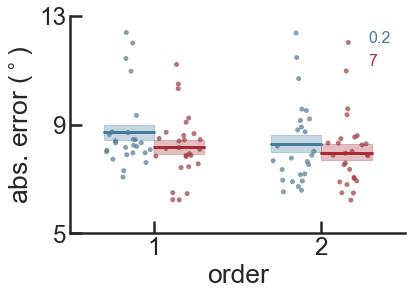

In [25]:
linares_plot(x='order', y='A_err_abs', hue='delay', df= df_analysis, 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=500,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(5,13)
plt.yticks([5,9,13])
#plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'abs. error ($^\circ$)');
#plt.title('close trials: SOA & order')
#plt.show(block=False)
plt.savefig('C:\\Users\\David\\Desktop\\abs_err_tdoa.svg', transparent=True )

In [20]:
result = smf.mixedlm(formula="A_err_abs ~ ord_del_cond", data=df_analysis, groups='subject').fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   A_err_abs  
No. Observations:    6362      Method:               REML       
No. Groups:          27        Scale:                32.8940    
Min. group size:     107       Likelihood:           -20171.8177
Max. group size:     354       Converged:            Yes        
Mean group size:     235.6                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              8.720    0.266 32.803 0.000  8.199  9.241
ord_del_cond[T.1_d7]  -0.513    0.205 -2.503 0.012 -0.914 -0.111
ord_del_cond[T.2_d02] -0.420    0.205 -2.044 0.041 -0.823 -0.017
ord_del_cond[T.2_d7]  -0.718    0.204 -3.526 0.000 -1.118 -0.319
subject Var            1.324    0.070                           



## Interference

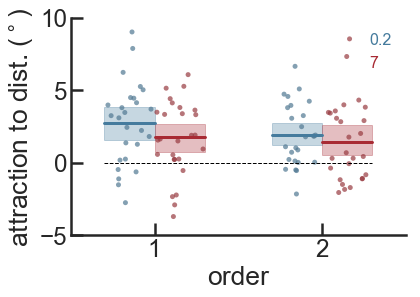

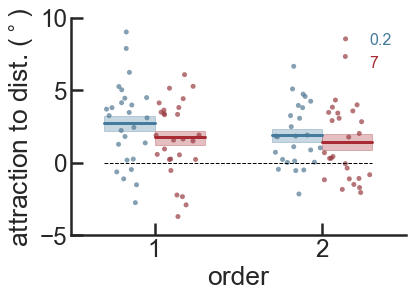

In [10]:
linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.95, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-5,10)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)



linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-5,10)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)




In [16]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 3920    Method:             REML          
No. Groups:       27      Scale:              23.4243       
Min. group size:  73      Likelihood:         -11794.1352   
Max. group size:  181     Converged:          Yes           
Mean group size:  145.2                                     
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      3.528     0.561   6.285  0.000   2.428   4.628
delay         -0.216     0.072  -2.985  0.003  -0.357  -0.074
order         -0.849     0.228  -3.725  0.000  -1.295  -0.402
delay:order    0.083     0.046   1.831  0.067  -0.006   0.173
subject Var    4.981     0.296                               



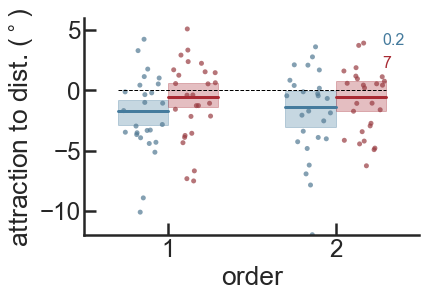

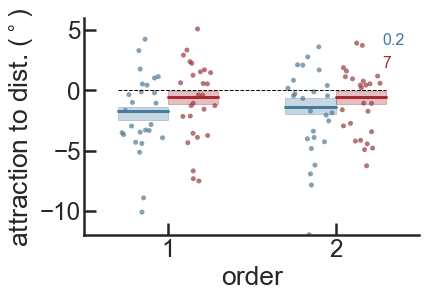

In [16]:
linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.95, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-12,6)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)



linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-12,6)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)


In [15]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay+order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 2442    Method:             REML          
No. Groups:       27      Scale:              26.2033       
Min. group size:  34      Likelihood:         -7496.7699    
Max. group size:  176     Converged:          Yes           
Mean group size:  90.4                                      
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -2.357     0.682  -3.456  0.001  -3.694  -1.020
delay          0.204     0.096   2.118  0.034   0.015   0.393
order          0.359     0.304   1.181  0.238  -0.237   0.955
delay:order   -0.048     0.061  -0.795  0.427  -0.168   0.071
subject Var    6.252     0.359                               

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Var

In [ ]:
## combined

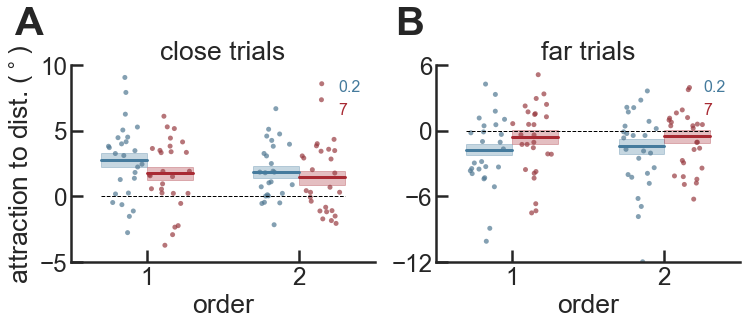

In [36]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)



f.text(0.06, 0.95, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.5, 0.95, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)



plt.subplot(221)

linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=500,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-5,10)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
plt.title('close trials')


plt.subplot(222)

linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=500,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'');
plt.title('far trials');

plt.savefig('C:\\Users\\David\\Desktop\\behaviour_tdoa_attraction_68.svg', transparent=True )

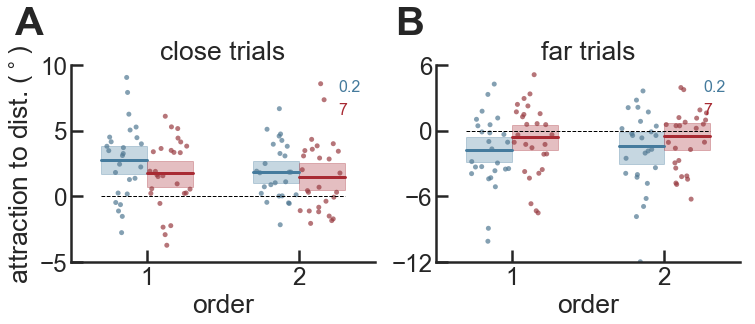

In [35]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)



f.text(0.06, 0.95, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.5, 0.95, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)



plt.subplot(221)

linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=500,
            CI=0.95, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-5,10)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
plt.title('close trials')


plt.subplot(222)

linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=500,
            CI=0.95, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'');
plt.title('far trials');

plt.savefig('C:\\Users\\David\\Desktop\\behaviour_tdoa_attraction.svg', transparent=True )

In [10]:
### Connecting plots in each environment and total

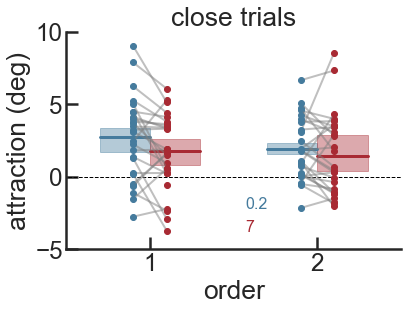

In [47]:
col_02 = '#457b9d'
col_7 = '#a82a33'

linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=10, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('close trials')

inc_=-0.1
inc=0.1

for i in df_analysis.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==1)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==2)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


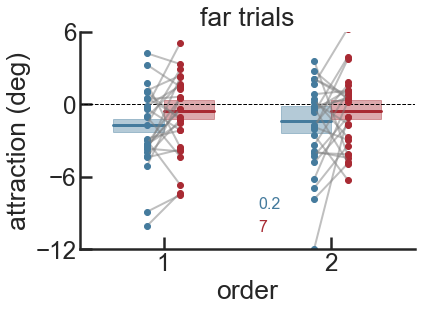

In [48]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=10, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.title('far trials')

inc_=-0.1
inc=0.1

for i in df_analysis.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==1)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==2)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [49]:
#### Just psychophysics

In [43]:
col_02 = 'darkblue'
col_7 = 'darkorange'

df_psy = df_analysis.loc[df_analysis['environment']=='psychophysics']

In [51]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out", data=df_psy, 
                     groups='subject').fit()
print(result.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     distance_A_err
No. Observations:      4475        Method:                 REML          
No. Groups:            21          Scale:                  28.4820       
Min. group size:       107         Likelihood:             -13905.2907   
Max. group size:       223         Converged:              No            
Mean group size:       213.1                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       4.106    1.252  3.279 0.001  1.652  6.560
dist_in_out[T.out]             -6.506    0.794 -8.190 0.000 -8.062 -4.949
delay                          -0.188    0.091 -2.058 0.040 -0.366 -0.009
delay:dist_in_out[T.out]        0.321    0.158  2.034 0.

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


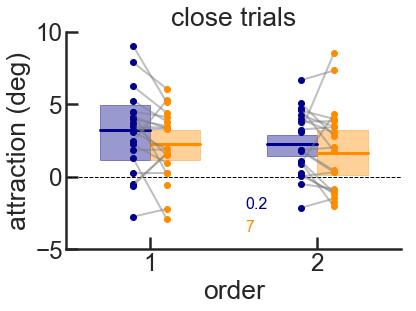

In [52]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=10, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('close trials')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [53]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='in'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='in','subject']).fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 2981    Method:             REML          
No. Groups:       21      Scale:              22.4896       
Min. group size:  73      Likelihood:         -8910.5899    
Max. group size:  152     Converged:          Yes           
Mean group size:  142.0                                     
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      3.972     0.653   6.079  0.000   2.691   5.252
delay         -0.168     0.081  -2.076  0.038  -0.327  -0.009
order         -0.911     0.258  -3.534  0.000  -1.417  -0.406
delay:order    0.052     0.051   1.024  0.306  -0.048   0.153
Group Var      5.454     0.376                               



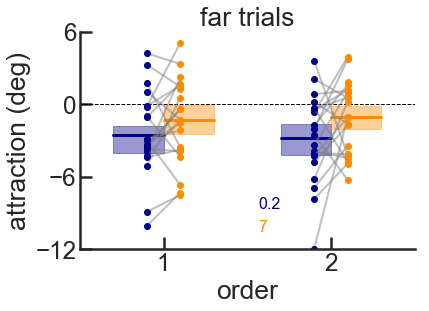

In [54]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=10, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.title('far trials')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [55]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

result = smf.mixedlm(formula="distance_A_err ~ delay+order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 1494    Method:             REML          
No. Groups:       21      Scale:              26.0700       
Min. group size:  34      Likelihood:         -4588.3318    
Max. group size:  78      Converged:          Yes           
Mean group size:  71.1                                      
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -2.055     0.834  -2.465  0.014  -3.688  -0.421
delay          0.071     0.123   0.579  0.563  -0.170   0.313
order         -0.293     0.391  -0.750  0.453  -1.060   0.473
delay:order    0.074     0.078   0.951  0.341  -0.078   0.227
Group Var      6.470     0.427                               

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Var

In [56]:
#### Just fMRI

In [44]:
col_02 = 'cadetblue'
col_7 = 'peru'

df_fmri = df_analysis.loc[df_analysis['environment']=='fMRI']

In [58]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out", data=df_fmri, 
                     groups='subject').fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     distance_A_err
No. Observations:      1887        Method:                 REML          
No. Groups:            6           Scale:                  27.4134       
Min. group size:       272         Likelihood:             -5811.9230    
Max. group size:       354         Converged:              Yes           
Mean group size:       314.5                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.100    0.854  2.461 0.014  0.427  3.773
dist_in_out[T.out]             -4.023    1.101 -3.655 0.000 -6.180 -1.866
delay                          -0.384    0.161 -2.387 0.017 -0.699 -0.069
delay:dist_in_out[T.out]        0.799    0.226  3.544 0.

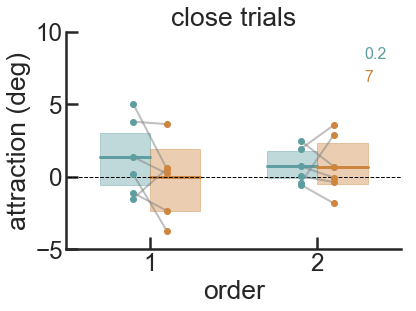

In [59]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_fmri.loc[df_fmri['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=10, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('close trials')

inc_=-0.1
inc=0.1

for i in df_fmri.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==1)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==2)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [60]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_fmri.loc[ df_fmri['dist_in_out']=='in'], 
                     groups=df_fmri.loc[ df_fmri['dist_in_out']=='in','subject']).fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 939     Method:             REML          
No. Groups:       6       Scale:              26.3215       
Min. group size:  135     Likelihood:         -2876.4672    
Max. group size:  181     Converged:          Yes           
Mean group size:  156.5                                     
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      2.028     0.940   2.158  0.031   0.186   3.870
delay         -0.387     0.158  -2.453  0.014  -0.696  -0.078
order         -0.664     0.483  -1.375  0.169  -1.610   0.283
delay:order    0.192     0.099   1.946  0.052  -0.001   0.385
Group Var      1.779     0.240                               



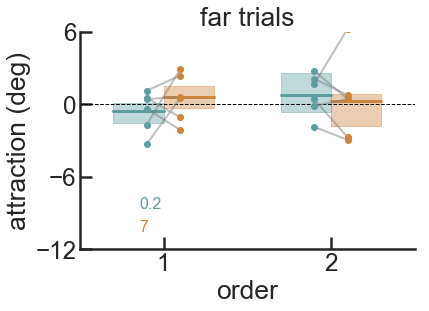

In [63]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_fmri.loc[df_fmri['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=10, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.title('far trials')

inc_=-0.1
inc=0.1

for i in df_fmri.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==1)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==2)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [62]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

result = smf.mixedlm(formula="distance_A_err ~ delay+order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 1494    Method:             REML          
No. Groups:       21      Scale:              26.0700       
Min. group size:  34      Likelihood:         -4588.3318    
Max. group size:  78      Converged:          Yes           
Mean group size:  71.1                                      
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -2.055     0.834  -2.465  0.014  -3.688  -0.421
delay          0.071     0.123   0.579  0.563  -0.170   0.313
order         -0.293     0.391  -0.750  0.453  -1.060   0.473
delay:order    0.074     0.078   0.951  0.341  -0.078   0.227
Group Var      6.470     0.427                               

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Var

In [64]:
##togeteher

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\David\Anaconda3\envs\python3\lib\site-p

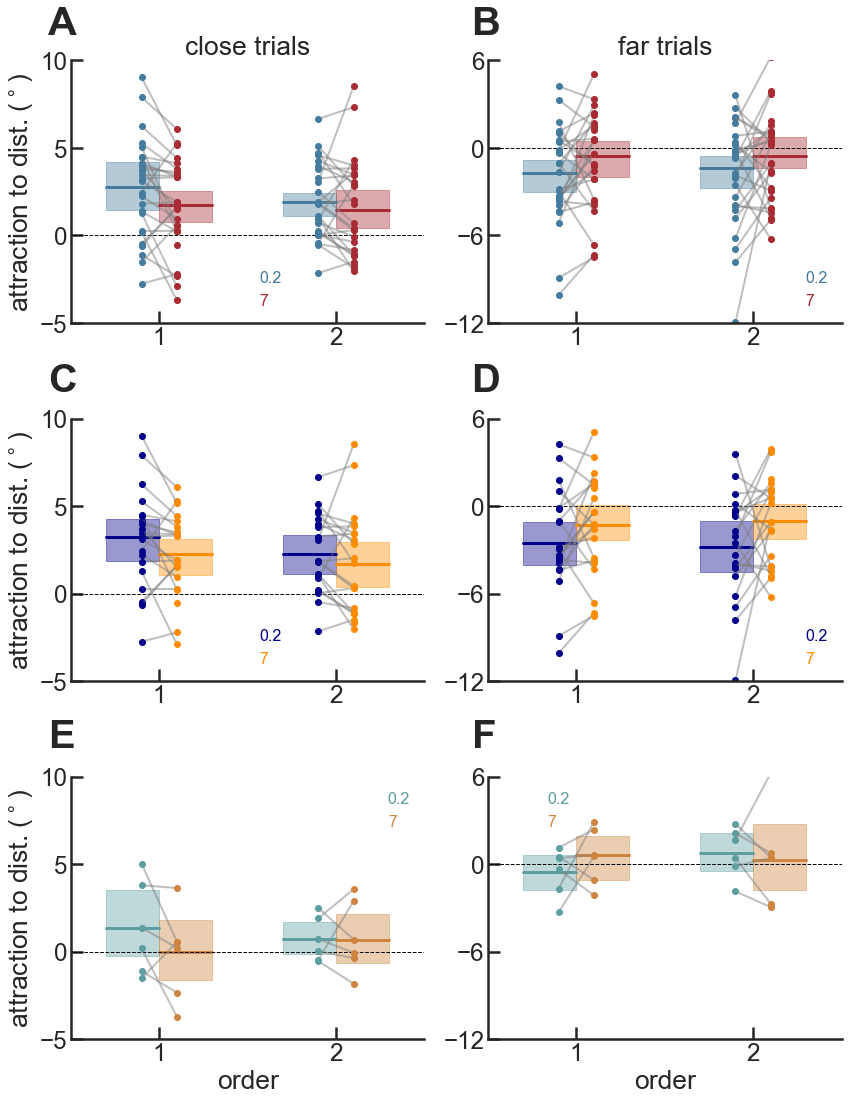

In [78]:
f = plt.figure(figsize=(12,15))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)



f.text(0.06, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.55, 1.0, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)

f.text(0.06, 0.67, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.55, 0.67, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)

f.text(0.06, 0.34, "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.55, 0.34, "F", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)

reps_ = 100



plt.subplot(321)

col_02 = '#457b9d'
col_7 = '#a82a33'

linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=reps_, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
plt.xlabel('')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('close trials')

inc_=-0.1
inc=0.1

for i in df_analysis.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==1)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==2)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


    

plt.subplot(322)

linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=reps_, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('')
plt.xlabel('')
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.title('far trials')

inc_=-0.1
inc=0.1

for i in df_analysis.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==1)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==2)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


plt.subplot(323)

col_02 = 'darkblue'
col_7 = 'darkorange'

linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=reps_, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
plt.xlabel('')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


plt.subplot(324)
    
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=reps_, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('')
plt.xlabel('')
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.title('')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )

    
    
plt.subplot(325)

col_02 = 'cadetblue'
col_7 = 'peru'

linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_fmri.loc[df_fmri['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=reps_, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
plt.xlabel('order')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('')

inc_=-0.1
inc=0.1

for i in df_fmri.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==1)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==2)& (df_fmri['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )




plt.subplot(326)

linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_fmri.loc[df_fmri['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=reps_, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('')
plt.xlabel('order')
plt.ylim(-12,6)
plt.yticks([-12, -6,0,6])
plt.title('')

inc_=-0.1
inc=0.1

for i in df_fmri.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==1) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==1)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==1)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7) & (df_fmri['order']==2) & (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==0.2) & (df_fmri['order']==2)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_fmri.loc[(df_fmri['subject']==i) & (df_fmri['delay']==7)& (df_fmri['order']==2)& (df_fmri['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


    
plt.tight_layout(h_pad=6) #h_pad
plt.savefig('C:\\Users\\David\\Desktop\\behaviour_tdoa_environments.svg', transparent=True )

## Distance effects in interference

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:120: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:120: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:120: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)


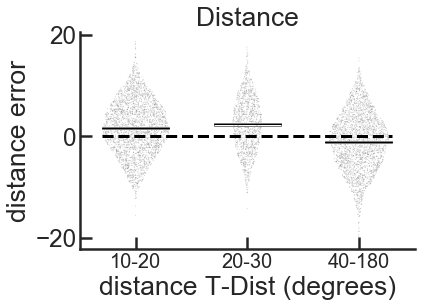

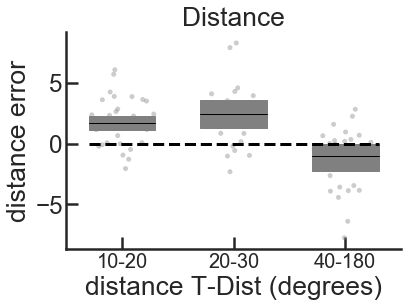

In [35]:
linares_plot(x='type', y='distance_A_err', df= df_analysis, palette=['grey'], 
              order=[1,2,3],  point_size=1, alpha=0.4, width=0.6, sep_axis=False, 
             reps=100)  
#plt.ylim(2,8)
plt.title('Distance')
plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel('distance error')
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel('distance T-Dist (degrees)')
plt.show(block=False)



linares_plot(x='type', y='distance_A_err', df= df_analysis, palette=['grey'], 
              order=[1,2,3],  point_size=5, alpha=0.4, width=0.6, by_subj=True, subj_col='subject',
              reps=100, sep_axis=False, fill_box=True)  
#plt.ylim(2,8)
plt.title('Distance')
plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel('distance error')
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel('distance T-Dist (degrees)')
plt.show(block=False)


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:120: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)


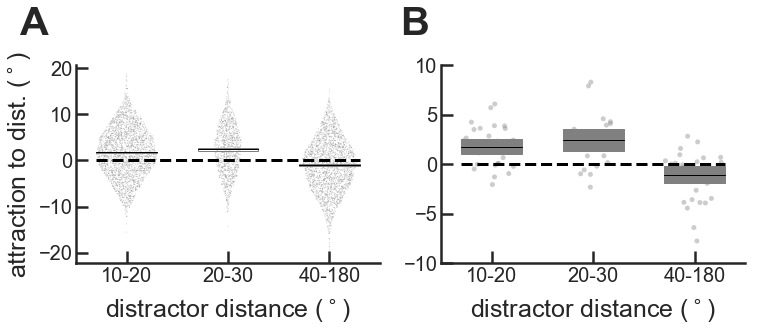

In [48]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)



f.text(0.06, 0.95, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.5, 0.95, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)



plt.subplot(221)

linares_plot(x='type', y='distance_A_err', df= df_analysis, palette=['grey'], 
              order=[1,2,3],  point_size=1, alpha=0.4, width=0.6, sep_axis=False, 
             reps=500)  
#plt.ylim(2,8)

plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel(r'attraction to dist. ($^\circ$)', fontsize=25);
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel(r'distractor distance ($^\circ$)', fontsize=25, labelpad=12)
plt.yticks([-20,-10, 0,10, 20], fontsize=20)


plt.subplot(222)

linares_plot(x='type', y='distance_A_err', df= df_analysis, palette=['grey'], 
              order=[1,2,3],  point_size=5, alpha=0.4, width=0.6, by_subj=True, subj_col='subject',
              reps=500, sep_axis=False, fill_box=True)  
#plt.ylim(2,8)

plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel(r'');
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel(r'distractor distance ($^\circ$)', fontsize=25, labelpad=12)
plt.ylim(-10,10)
plt.yticks([-10, -5,0,5,10], fontsize=20);

plt.savefig('C:\\Users\\David\\Desktop\\behaviour_tdoa_distance.svg', transparent=True )

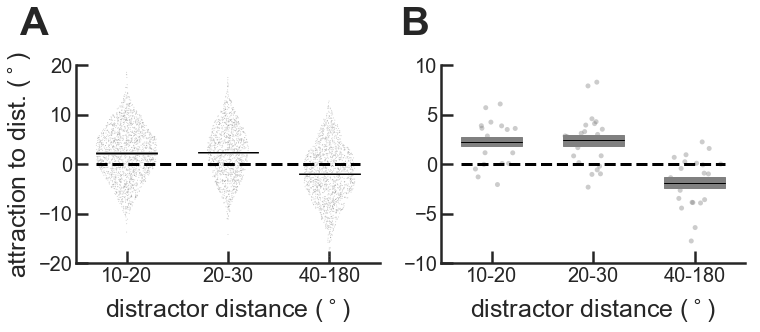

In [53]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)



f.text(0.06, 0.95, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)
f.text(0.5, 0.95, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=40)



plt.subplot(221)

linares_plot(x='type', y='distance_A_err', df= df_psy, palette=['grey'], CI=0.68,
              order=[1,2,3],  point_size=1, alpha=0.4, width=0.6, sep_axis=False, 
             reps=500)  
#plt.ylim(2,8)

plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel(r'attraction to dist. ($^\circ$)', fontsize=25);
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel(r'distractor distance ($^\circ$)', fontsize=25, labelpad=12)
plt.ylim(-20,20)
plt.yticks([-20,-10, 0,10, 20], fontsize=20)


plt.subplot(222)

linares_plot(x='type', y='distance_A_err', df= df_psy, palette=['grey'], CI=0.68,
              order=[1,2,3],  point_size=5, alpha=0.4, width=0.6, by_subj=True, subj_col='subject',
              reps=500, sep_axis=False, fill_box=True)  
#plt.ylim(2,8)

plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel(r'');
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel(r'distractor distance ($^\circ$)', fontsize=25, labelpad=12)
plt.ylim(-10,10)
plt.yticks([-10, -5,0,5,10], fontsize=20);

plt.savefig('C:\\Users\\David\\Desktop\\behaviour_tdoa_distance_psy.svg', transparent=True )

In [46]:
##### MEAN OF CW AND CCW COLLAPSING IN 

means_cw={}

for Subj in df_psy.subject.unique():
    d_subj = df_psy.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for Dist in df_psy.type.unique():
            for Cond_4 in df_psy.ord_del_cond.unique():
                mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['ord_del_cond']==Cond_4) &
                                           (d_subj['type']==Dist), 'A_err_theoretical'   ].mean(), 3)
                means_cw[str(Subj)  + '_' + str(Cond_4) + '_' + str(Dist) + '_' + ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df_psy.index:
    or_ = df_psy.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df_psy.loc[i, 'subject'])+ '_' + df_psy.loc[i, 'ord_del_cond'] +'_' + str(df_psy.loc[i, 'type']) + '_'+ or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append( (df_psy.loc[i, 'A_err_theoretical'] - means_cw[idx])/2 )  
    elif or_ =='cw':
        cw_ccw_distance.append( (means_cw[idx] - df_psy.loc[i, 'A_err_theoretical'])/2 )  
    else:
        print('Error')
    


df_psy['distance_A_err_3_dist_p'] = cw_ccw_distance

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
result = smf.mixedlm(formula="distance_A_err_3_dist ~C(type) ", data=df_psy, 
                     groups=df_psy['subject']).fit()
print(result.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err_3_dist
No. Observations: 4475    Method:             REML                 
No. Groups:       21      Scale:              29.9198              
Min. group size:  107     Likelihood:         -14009.0912          
Max. group size:  223     Converged:          No                   
Mean group size:  213.1                                            
--------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept            2.179     1.201    1.814  0.070  -0.175   4.532
C(type)[T.2.0]       0.407     0.205    1.991  0.047   0.006   0.809
C(type)[T.3.0]      -4.099     0.192  -21.345  0.000  -4.475  -3.722
Group Var           29.920                                          



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [48]:
result = smf.mixedlm(formula="distance_A_err_3_dist_p ~C(type) ", data=df_psy, 
                     groups=df_psy['subject']).fit()
print(result.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err_3_dist_p
No. Observations: 4475    Method:             REML                   
No. Groups:       21      Scale:              29.9198                
Min. group size:  107     Likelihood:         -14009.0912            
Max. group size:  223     Converged:          No                     
Mean group size:  213.1                                              
-----------------------------------------------------------------------
                  Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept          2.179      1.201     1.814   0.070   -0.175    4.532
C(type)[T.2.0]     0.407      0.205     1.991   0.047    0.006    0.809
C(type)[T.3.0]    -4.099      0.192   -21.345   0.000   -4.475   -3.722
Group Var         29.920                                               



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
